
# **Implementing a Decision Tree for Random Forest**

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/salary_data_cleaned.csv")

# Select relevant features
features = ['Rating', 'Location', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'hourly',
            'employer_provided', 'avg_salary', 'same_state', 'age', 'python_yn', 'spark', 'aws', 'excel',
            'Job Title', 'math', 'engineering', 'data analysis', 'AI']

dataset = df[features]

# One-hot encode categorical features
df_dum = pd.get_dummies(dataset)

# Ensure 'avg_salary' is correctly included in df_dum
if 'avg_salary' not in df_dum.columns:
    raise KeyError("'avg_salary' not found in one-hot encoded dataframe")

# Define features and target variable
X = df_dum.drop('avg_salary', axis=1).values
y = df_dum['avg_salary'].values

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class D_TreeRegressor:

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape

        if num_samples >= self.min_samples_split and (self.max_depth is None or depth < self.max_depth):
            best_split = self._find_best_split(X, y, num_features)

            if best_split and best_split['variance_reduction'] > 0:
                left_indices = best_split['left_indices']
                right_indices = best_split['right_indices']

                left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
                right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

                return Node(feature_index=best_split['feature_index'],
                            threshold=best_split['threshold'],
                            left=left_subtree,
                            right=right_subtree)

        leaf_value = np.mean(y)
        return Node(value=leaf_value)

    def _find_best_split(self, X, y, num_features):
        best_split = None
        max_variance_reduction = -float('inf')

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)

            for threshold in unique_values:
                left_indices = np.where(feature_values <= threshold)[0]
                right_indices = np.where(feature_values > threshold)[0]

                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue

                variance_reduction = self._calculate_variance_reduction(y, y[left_indices], y[right_indices])
                if variance_reduction > max_variance_reduction:
                    max_variance_reduction = variance_reduction
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'variance_reduction': variance_reduction
                    }

        return best_split

    def _calculate_variance_reduction(self, y, y_left, y_right):
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        reduction = np.var(y) - (weight_left * np.var(y_left) + weight_right * np.var(y_right))
        return reduction

    def predict(self, X):
        return np.array([self._predict_value(x, self.tree) for x in X])

    def _predict_value(self, x, tree):
        if tree.value is not None:
            return tree.value

        if x[tree.feature_index] <= tree.threshold:
            return self._predict_value(x, tree.left)
        else:
            return self._predict_value(x, tree.right)


class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


# Function to calculate mean squared error
def mean_squared_error_custom(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


# Function to calculate R^2 (coefficient of determination)
def r2_score_custom(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    explained_variance = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (explained_variance / total_variance)
    return r2


# Function to calculate mean absolute error
def mean_absolute_error_custom(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# Training the model
regressor = D_TreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2)
regressor.fit(X_train, y_train)

# Making predictions on the test set
predictions = regressor.predict(X_test)


# **IMPLEMENTING RANDOM FOREST USING PYTHON LIBRARY**

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train and evaluate scikit-learn's RandomForestRegressor
sklearn_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
sklearn_regressor.fit(X_train, y_train)
predictions_sklearn = sklearn_regressor.predict(X_test)


**PERFORMANCE METRICS**

In [15]:
mse_sklearn = mean_squared_error(y_test, predictions_sklearn)
r2_sklearn = r2_score(y_test, predictions_sklearn)
mae_sklearn = mean_absolute_error(y_test, predictions_sklearn)

print("Mean Squared Error (Scikit-learn): ", mse_sklearn)
print("R-squared (Scikit-learn): ", r2_sklearn)
print("Mean Absolute Error (Scikit-learn): ", mae_sklearn)

Mean Squared Error (Scikit-learn):  756.9059153656441
R-squared (Scikit-learn):  0.5369221584291147
Mean Absolute Error (Scikit-learn):  21.019777880136456


# **IMPLEMENTING RANDOM FOREST WITHOUT USING PYTHON LIBRARY**

In [16]:
import numpy as np

class RandomForestRegressorCustom:
    def __init__(self, n_estimators=20, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.estimators = []

    def fit(self, X, y):
        print("Fitting Random Forest...")
        np.random.seed(self.random_state)
        self.estimators = []
        for i in range(self.n_estimators):
            print(f"Fitting estimator {i+1}/{self.n_estimators}...")
            np.random.seed(self.random_state + i)
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            tree = D_TreeRegressor(max_depth=self.max_depth,
                                   min_samples_split=self.min_samples_split,
                                   min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators.append(tree)
        print("Training complete.")

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.estimators):
            predictions[:, i] = tree.predict(X)
        return np.mean(predictions, axis=1)

# Custom function to calculate mean squared error
def mean_squared_error_custom(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Custom function to calculate R^2 (coefficient of determination)
def r2_score_custom(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    explained_variance = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (explained_variance / total_variance)
    return r2

# Custom function to calculate mean absolute error
def mean_absolute_error_custom(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Assuming your dataset loading and preprocessing steps are defined as before

# Instantiate and train the custom random forest regressor
regressor_custom = RandomForestRegressorCustom(n_estimators=20, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
regressor_custom.fit(X_train, y_train)

# Making predictions on the test set
predictions_custom = regressor_custom.predict(X_test)


Fitting Random Forest...
Fitting estimator 1/20...
Fitting estimator 2/20...
Fitting estimator 3/20...
Fitting estimator 4/20...
Fitting estimator 5/20...
Fitting estimator 6/20...
Fitting estimator 7/20...
Fitting estimator 8/20...
Fitting estimator 9/20...
Fitting estimator 10/20...
Fitting estimator 11/20...
Fitting estimator 12/20...
Fitting estimator 13/20...
Fitting estimator 14/20...
Fitting estimator 15/20...
Fitting estimator 16/20...
Fitting estimator 17/20...
Fitting estimator 18/20...
Fitting estimator 19/20...
Fitting estimator 20/20...
Training complete.


**PERFORMANCE METRICS**

In [17]:
# Calculating MSE, R², and MAE on the test set using custom functions
mse_custom = mean_squared_error_custom(y_test, predictions_custom)
r2_custom = r2_score_custom(y_test, predictions_custom)
mae_custom = mean_absolute_error_custom(y_test, predictions_custom)

print("Mean Squared Error (Custom): ", mse_custom)
print("R-squared (Custom): ", r2_custom)
print("Mean Absolute Error (Custom): ", mae_custom)

Mean Squared Error (Custom):  750.684659448968
R-squared (Custom):  0.5407283458340088
Mean Absolute Error (Custom):  20.935171994053448


 **Evaluating RandomForestRegressor Performance Across Different Tree Depths**

This Code block evaluates the performance of a Random Forest Regressor on training and testing datasets by varying the tree depth and computing the mean squared error (MSE) for each depth level.

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

train_errors = []
test_errors = []
values = range(1, 21)  # Example range for tree depths

for i in values:
    # Configure the model
    model =RandomForestRegressor(n_estimators=100, max_depth=i, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)

    # Fit model on the training dataset
    model.fit(X_train, y_train)
    # Evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_yhat)
    train_errors.append(train_mse)
    # Evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_yhat)
    test_errors.append(test_mse)
    # Summarize progress
    print(f'>{i}, train MSE: {train_mse:.3f}, test MSE: {test_mse:.3f}')


>1, train MSE: 1226.013, test MSE: 1451.267
>2, train MSE: 1111.535, test MSE: 1295.399
>3, train MSE: 986.769, test MSE: 1201.378
>4, train MSE: 867.370, test MSE: 1115.146
>5, train MSE: 755.862, test MSE: 1042.947
>6, train MSE: 661.217, test MSE: 963.018
>7, train MSE: 583.963, test MSE: 899.844
>8, train MSE: 514.815, test MSE: 843.513
>9, train MSE: 454.297, test MSE: 800.695
>10, train MSE: 400.943, test MSE: 756.906
>11, train MSE: 354.127, test MSE: 708.887
>12, train MSE: 313.971, test MSE: 674.078
>13, train MSE: 279.832, test MSE: 644.504
>14, train MSE: 253.499, test MSE: 619.445
>15, train MSE: 232.711, test MSE: 609.141
>16, train MSE: 217.808, test MSE: 593.844
>17, train MSE: 204.883, test MSE: 581.656
>18, train MSE: 195.490, test MSE: 574.732
>19, train MSE: 187.292, test MSE: 572.398
>20, train MSE: 182.425, test MSE: 563.846


**Visualizing the Impact of Model Complexity on Mean Squared Error for Random Forest Regressor**

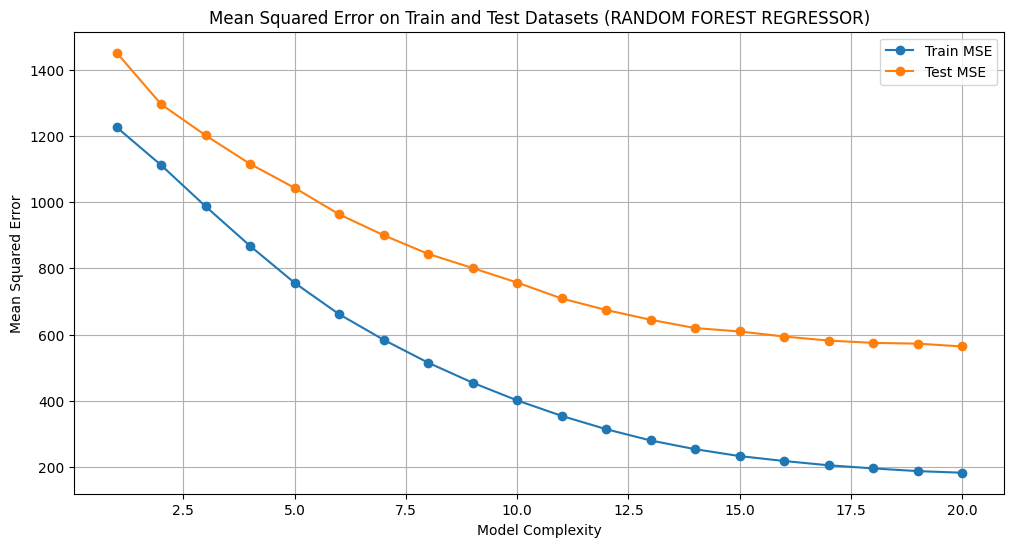

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(values, train_errors, marker='o', label='Train MSE')
plt.plot(values, test_errors, marker='o', label='Test MSE')
plt.xlabel('Model Complexity')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error on Train and Test Datasets (RANDOM FOREST REGRESSOR)')
plt.legend()
plt.grid(True)
plt.show()